# Полный анализ данных — Sleep Health and Lifestyle

Ноутбук выполняет полный анализ данных (загрузка, очистка, обработка, визуализация, группировки и агрегации). Используется только локальный CSV-файл.

In [1]:
# 0. Импорты и настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Настройки отображения
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = (10,6)

# Путь к локальному файлу
CSV_PATH = r'Sleep_health_and_lifestyle_dataset.csv'
print("Файл для загрузки:", CSV_PATH)

Файл для загрузки: Sleep_health_and_lifestyle_dataset.csv


## A. Загрузка и первичный обзор

In [2]:
# A.1 Загрузка данных
df = pd.read_csv(CSV_PATH)
print('Размер датасета:', df.shape)
df.head()

Размер датасета: (374, 13)


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [3]:
# Показать последние строки
df.tail()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
373,374,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


In [4]:
# A.2 Структура данных и типы
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [5]:
# Попытка корректировки типов: пытаемся привести числовые колонки к числовым типам
for col in df.columns:
    # если колонка содержит числа, но dtype - object, попробуем привести
    if df[col].dtype == 'object':
        # попробуем удалить запятые и пробелы и привести к числу
        coerced = pd.to_numeric(df[col].str.replace(',', '.').str.strip(), errors='coerce')
        # если значительная часть успешно конвертируется, заменим колонку
        if coerced.notna().sum() / len(df) > 0.5:
            df[col] = coerced
            print(f"Колонка {col} приведена к числовому типу.")
df.dtypes

Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

## B. Обработка данных

In [6]:
# B.1 Пропуски
missing_per_col = df.isna().sum().sort_values(ascending=False)
missing_per_col

Sleep Disorder             0
Daily Steps                0
Heart Rate                 0
Blood Pressure             0
BMI Category               0
Stress Level               0
Physical Activity Level    0
Quality of Sleep           0
Sleep Duration             0
Occupation                 0
Age                        0
Gender                     0
Person ID                  0
dtype: int64

In [7]:
# Процент пропусков
(missing_per_col / len(df) * 100).round(2)

Sleep Disorder             0.0
Daily Steps                0.0
Heart Rate                 0.0
Blood Pressure             0.0
BMI Category               0.0
Stress Level               0.0
Physical Activity Level    0.0
Quality of Sleep           0.0
Sleep Duration             0.0
Occupation                 0.0
Age                        0.0
Gender                     0.0
Person ID                  0.0
dtype: float64

In [8]:
# Стратегии: если % пропусков небольшой — можно заполнить медианой/средним/модой; для категорий — модой.
# Мы напишем автоматическую логику: для числовых колонок — медиана (если <30% пропусков), для категорий — мода; если >50% — удалим колонку.
cols_to_drop = []
for col, miss in missing_per_col.items():
    pct = miss / len(df)
    if pct == 0:
        continue
    if pct > 0.5:
        cols_to_drop.append(col)
    else:
        if pd.api.types.is_numeric_dtype(df[col]):
            median = df[col].median()
            df[col] = df[col].fillna(median)
        else:
            mode = df[col].mode(dropna=True)
            if len(mode)>0:
                df[col] = df[col].fillna(mode[0])
            else:
                df[col] = df[col].fillna('Unknown')
print('Будут удалены колонки (>%):', cols_to_drop)
df = df.drop(columns=cols_to_drop)
print('Новый размер датасета:', df.shape)

Будут удалены колонки (>%): []
Новый размер датасета: (374, 13)


In [9]:
# Проверим пропуски снова
df.isna().sum().sort_values(ascending=False)

Sleep Disorder             0
Daily Steps                0
Heart Rate                 0
Blood Pressure             0
BMI Category               0
Stress Level               0
Physical Activity Level    0
Quality of Sleep           0
Sleep Duration             0
Occupation                 0
Age                        0
Gender                     0
Person ID                  0
dtype: int64

In [10]:
# B.2 Дубликаты
dup_count = df.duplicated().sum()
dup_count

0

In [11]:
# Если есть дубликаты - удалим их
if df.duplicated().sum() > 0:
    df = df.drop_duplicates().reset_index(drop=True)
    print('Удалены дубликаты. Новый размер:', df.shape)
else:
    print('Дубликатов не найдено')

Дубликатов не найдено


### B.3 Выбросы (outliers)
Будем использовать Z-score и визуально — boxplot. Рассмотрим числовые колонки.

In [12]:
# Числовые колонки
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols

['Person ID',
 'Age',
 'Sleep Duration',
 'Quality of Sleep',
 'Physical Activity Level',
 'Stress Level',
 'Heart Rate',
 'Daily Steps']

In [13]:
# Рассчитаем Z-score и пометим выбросы
from scipy.stats import zscore
z = df[num_cols].apply(lambda x: np.abs((x - x.mean())/x.std(ddof=0)))
outlier_mask = (z > 3)
outlier_counts = outlier_mask.sum().sort_values(ascending=False)
outlier_counts

Heart Rate                 9
Daily Steps                0
Stress Level               0
Physical Activity Level    0
Quality of Sleep           0
Sleep Duration             0
Age                        0
Person ID                  0
dtype: int64

In [14]:
# Покажем несколько примеров выбросов (по каждой колонке первые 5)
outliers_examples = {}
for col in num_cols:
    mask = outlier_mask[col]
    outliers_examples[col] = df.loc[mask, col].head(5).tolist()
outliers_examples

{'Person ID': [],
 'Age': [],
 'Sleep Duration': [],
 'Quality of Sleep': [],
 'Physical Activity Level': [],
 'Stress Level': [],
 'Heart Rate': [85, 85, 85, 84, 84],
 'Daily Steps': []}

In [15]:
# По желанию можно удалить выбросы: здесь просто отмечаем и оставляем (комментировано)
# df = df[(z < 3).all(axis=1)]
# print('Размер после удаления выбросов:', df.shape)
print('Удаление выбросов закомментировано — решение оставлено пользователю')

Удаление выбросов закомментировано — решение оставлено пользователю


## C. Статистики данных

In [16]:
# Описательная статистика
desc = df.describe(include='all').T
desc

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Person ID,374,NaN,NaN,NaN,187.5,108.109,1,94.25,187.5,280.75,374
Gender,374,2,Male,189,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,374,NaN,NaN,NaN,42.1845,8.67313,27,35.25,43,50,59
Occupation,374,11,Nurse,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sleep Duration,374,NaN,NaN,NaN,7.13209,0.795657,5.8,6.4,7.2,7.8,8.5
Quality of Sleep,374,NaN,NaN,NaN,7.31283,1.19696,4,6,7,8,9
Physical Activity Level,374,NaN,NaN,NaN,59.1711,20.8308,30,45,60,75,90
Stress Level,374,NaN,NaN,NaN,5.38503,1.77453,3,4,5,7,8
BMI Category,374,4,Normal,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Blood Pressure,374,25,130/85,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Уникальные значения и частоты для категориальных колонок (топ-10)
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
freqs = {col: df[col].value_counts().head(10) for col in cat_cols}
# Показать
for k,v in freqs.items():
    print('===', k, '===') 
    print(v)
    print()

=== Gender ===
Male      189
Female    185
Name: Gender, dtype: int64

=== Occupation ===
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Name: Occupation, dtype: int64

=== BMI Category ===
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: BMI Category, dtype: int64

=== Blood Pressure ===
130/85    99
125/80    65
140/95    65
120/80    45
115/75    32
135/90    27
140/90     4
125/82     4
128/85     3
132/87     3
Name: Blood Pressure, dtype: int64

=== Sleep Disorder ===
None           219
Sleep Apnea     78
Insomnia        77
Name: Sleep Disorder, dtype: int64



In [18]:
# Корреляционный анализ (пирсон)
corr = df[num_cols].corr(method='pearson')
corr

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
Person ID,1.000000,0.990516,0.296305,0.431612,0.149882,-0.394287,-0.225467,0.043844
Age,0.990516,1.000000,0.344709,0.473734,0.178993,-0.422344,-0.225606,0.057973
Sleep Duration,0.296305,0.344709,1.000000,0.883213,0.212360,-0.811023,-0.516455,-0.039533
Quality of Sleep,0.431612,0.473734,0.883213,1.000000,0.192896,-0.898752,-0.659865,0.016791
Physical Activity Level,0.149882,0.178993,0.212360,0.192896,1.000000,-0.034134,0.136971,0.772723
Stress Level,-0.394287,-0.422344,-0.811023,-0.898752,-0.034134,1.000000,0.670026,0.186829
Heart Rate,-0.225467,-0.225606,-0.516455,-0.659865,0.136971,0.670026,1.000000,-0.030309
Daily Steps,0.043844,0.057973,-0.039533,0.016791,0.772723,0.186829,-0.030309,1.000000


## D. Визуализация данных (минимум 5 графиков)
Графики: гистограмма, линейный график, столбчатая диаграмма, boxplot, heatmap корреляций.

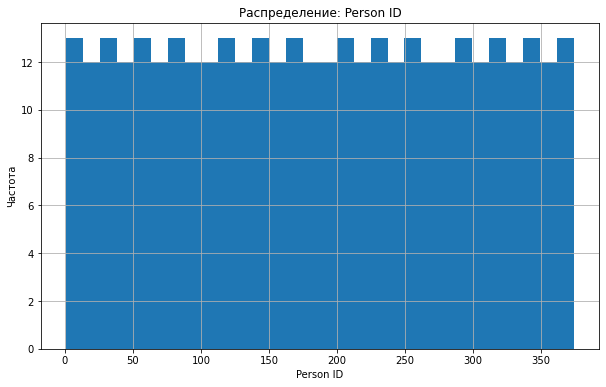

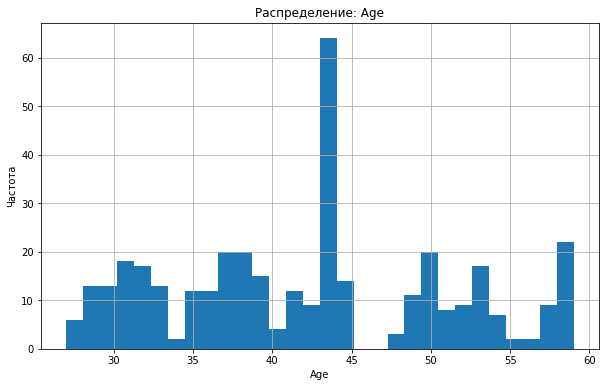

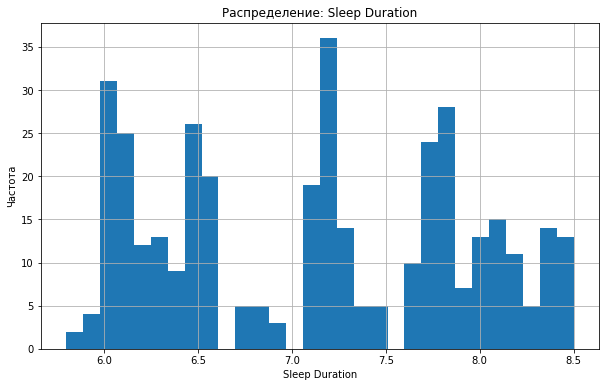

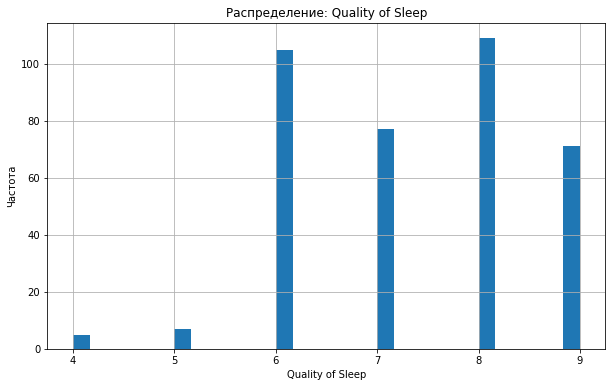

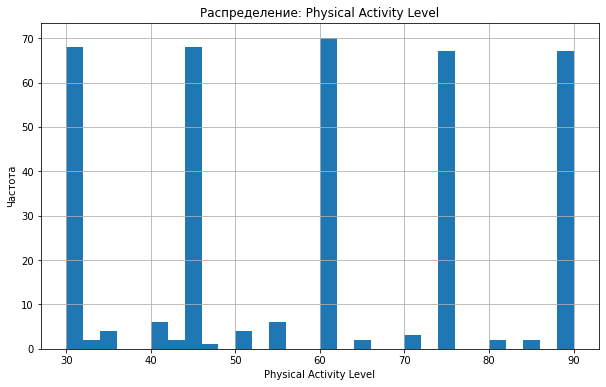

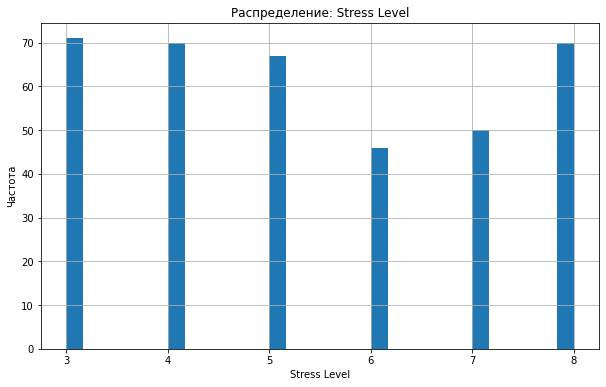

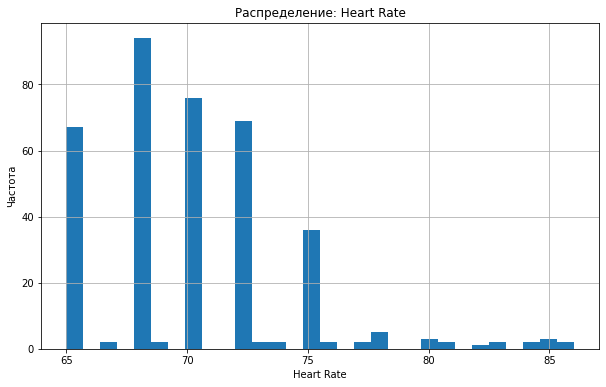

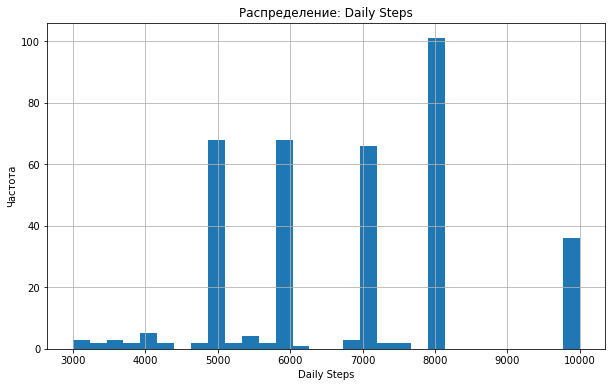

In [19]:
# 1) Гистограммы распределений для всех числовых колонок
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Распределение: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

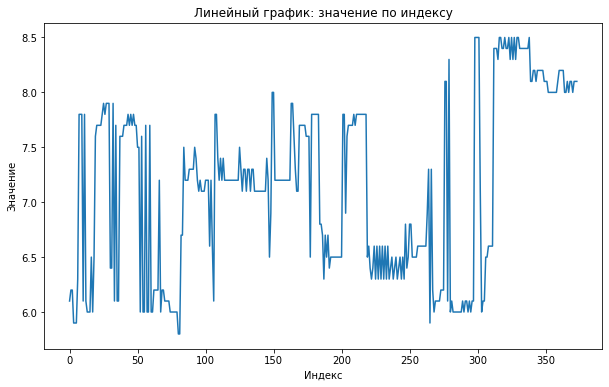

In [20]:
# 2) Линейный график — например Sleep Duration по индексу (или по Person ID, если он числовой)
plt.figure()
if 'Sleep Duration' in df.columns:
    y = df['Sleep Duration']
else:
    y = df[num_cols[0]] if num_cols else None
plt.plot(y.reset_index(drop=True))
plt.title('Линейный график: значение по индексу')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.show()

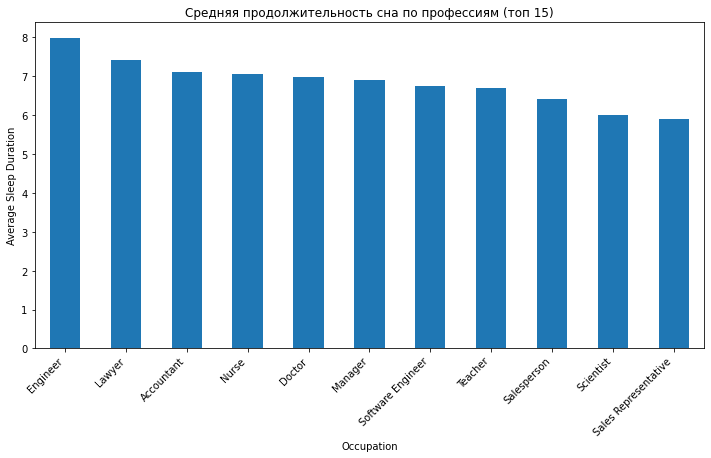

In [21]:
# 3) Столбчатая диаграмма: средняя Sleep Duration по Occupation (топ 15)
if 'Occupation' in df.columns and 'Sleep Duration' in df.columns:
    agg = df.groupby('Occupation')['Sleep Duration'].mean().sort_values(ascending=False).head(15)
    plt.figure(figsize=(12,6))
    agg.plot(kind='bar')
    plt.title('Средняя продолжительность сна по профессиям (топ 15)')
    plt.ylabel('Average Sleep Duration')
    plt.xticks(rotation=45, ha='right')
    plt.show()
else:
    print('Нет колонок Occupation/Sleep Duration для этого графика')

<Figure size 720x432 with 0 Axes>

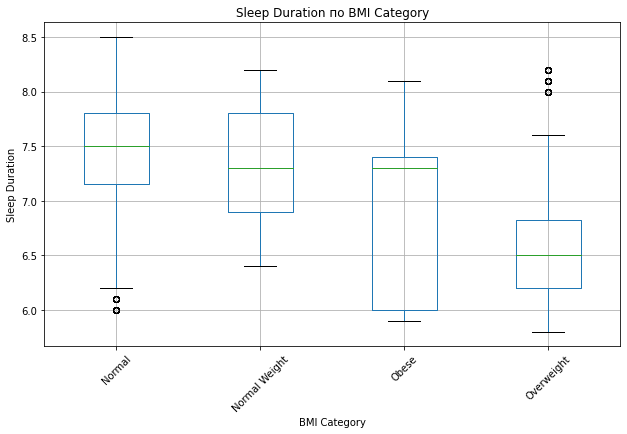

In [22]:
# 4) Boxplot для Sleep Duration по категории BMI (если есть)
if 'BMI Category' in df.columns and 'Sleep Duration' in df.columns:
    plt.figure(figsize=(10,6))
    df.boxplot(column='Sleep Duration', by='BMI Category', rot=45)
    plt.title('Sleep Duration по BMI Category')
    plt.suptitle('')
    plt.xlabel('BMI Category')
    plt.ylabel('Sleep Duration')
    plt.show()
else:
    print('Нет данных для boxplot по BMI Category')

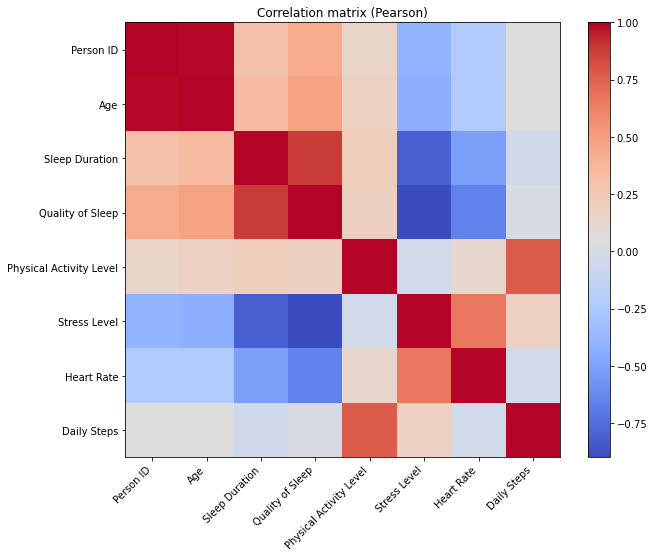

In [31]:
# 5) Heatmap корреляций (matplotlib imshow, без seaborn heatmap для совместимости)
plt.figure(figsize=(10,8))
c = corr.values
plt.imshow(c, interpolation='nearest', cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation matrix (Pearson)')
plt.show()

## E. Группировки и агрегации (groupby / pivot_table) — минимум 3 агрегации

In [24]:
# 1) Среднее и медиана Sleep Duration по Occupation
if 'Occupation' in df.columns and 'Sleep Duration' in df.columns:
    g1 = df.groupby('Occupation')['Sleep Duration'].agg(['mean','median','count']).sort_values('mean', ascending=False).head(20)
    display(g1)
else:
    print('Нет колонок Occupation/Sleep Duration')

,mean,median,count
Occupation,,,
Engineer,7.987302,8.3,63
Lawyer,7.410638,7.3,47
Accountant,7.113514,7.2,37
Nurse,7.063014,6.5,73
Doctor,6.970423,7.6,71
Manager,6.900000,6.9,1
Software Engineer,6.750000,6.8,4
Teacher,6.690000,6.6,40
Salesperson,6.403125,6.4,32


In [25]:
# 2) Подсчёт количества по сочетанию Gender и Sleep Disorder (если есть)
if 'Gender' in df.columns and 'Sleep Disorder' in df.columns:
    g2 = df.groupby(['Gender','Sleep Disorder']).size().unstack(fill_value=0)
    display(g2)
else:
    print('Нет колонок Gender/Sleep Disorder')

Sleep Disorder,Insomnia,None,Sleep Apnea
Gender,,,
Female,36,82,67
Male,41,137,11


In [26]:
# 3) Pivot table: среднее Physical Activity Level по Occupation и Gender (если есть)
if 'Physical Activity Level' in df.columns and 'Occupation' in df.columns and 'Gender' in df.columns:
    pt = pd.pivot_table(df, values='Physical Activity Level', index='Occupation', columns='Gender', aggfunc='mean')
    display(pt.head(20))
else:
    print('Не хватает колонок для pivot_table')

Gender,Female,Male
Occupation,,
Accountant,58.333333,50.000000
Doctor,90.000000,54.347826
Engineer,30.000000,74.419355
Lawyer,55.000000,71.111111
Manager,55.000000,NaN
Nurse,78.589041,NaN
Sales Representative,NaN,30.000000
Salesperson,NaN,45.000000
Scientist,41.000000,NaN


## F. Сохранение результата и рекомендации
- Сохраним чистую версию датасета (после удаления колонок/дубликатов/заполнения пропусков) в `cleaned_sleep_dataset.csv`.

In [27]:
# Сохраним очищенный датасет
out_path = 'cleaned_sleep_dataset.csv'
df.to_csv(out_path, index=False)
print('Очищенный датасет сохранён в', out_path)

Очищенный датасет сохранён в cleaned_sleep_dataset.csv


## Заключение и дальнейшие шаги
1. Проверить, правильно ли сопоставлены и названы колонки (особенно если оригинальный проект ожидал другие имена).
2. При необходимости — удалить выбросы или заменить стратегию заполнения пропусков.
3. Добавить дополнительные визуализации или ML-модель (классификация плохого качества сна и т.д.).